In [1]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os

In [2]:
import PF
import ROI
importlib.reload(PF)
importlib.reload(ROI)

<module 'ROI' from 'C:\\Users\\krq\\Documents\\GitHub\\radwatch-analysis\\ROI.py'>

In [3]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx
        
def plot_peak_region(spectrum,source_energies,source_isotopes):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    print(target_peaks)
    for i,j,isotope in zip(source_energies,target_peaks,source_isotopes):
        spec = spectrum
        counts = spec.counts_vals
        energies = spec.energies_kev
        idx = f_near(energies,i) 
        roi_low = idx - 50
        roi_high = idx + 50

        plot_counts = counts[roi_low:roi_high]
        plot_energies = energies[roi_low:roi_high]

        roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(j)
        rlow = roi_low_bins[0][0]
        rhi = roi_high_bins[0][-1]
        plot_counts = counts[rlow:rhi]
        plot_energies = energies[rlow:rhi]

        rlow = roi_low_bins[0][0]
        rhi = roi_low_bins[0][-1]
        low_counts = counts[rlow:rhi]
        low_energies = energies[rlow:rhi]

        rlow = roi_high_bins[0][0]
        rhi = roi_high_bins[0][-1]
        high_counts = counts[rlow:rhi]
        high_energies = energies[rlow:rhi]

        rlow = roi_peak_bins[0][0]
        rhi = roi_peak_bins[0][-1]
        peak_counts = counts[rlow:rhi]
        peak_energies = energies[rlow:rhi]

        fig,ax = plt.subplots()
        ax.plot(plot_energies,plot_counts)
        ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
        ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
        ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
        ax.set_yscale('log')
        plt.title(isotope)
        #plt.savefig('isotope %s.png'%isotope,dpi = 200)
        
def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spectrum.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spectrum.livetime)
    return eff, eff_uncer

In [4]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)
        
        


In [5]:
spec = r'C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe'
bg = r'C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe'
spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)

SpeFile: Reading file C:\rad data\Radwatch data\efficiency_calibration_2020-3-5.Spe


C:\anaconda3\lib\site-packages\becquerel\parsers\spectrum_file.py:136: SpectrumFileParsingWarning: Spectrum will be initated without an energy calibration;invalid calibration, energies not monotonically increasing.
  SpectrumFileParsingWarning)


SpeFile: Reading file C:\rad data\Radwatch data\Background_Spectrum_12_20_19.Spe


In [6]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

C:\anaconda3\lib\site-packages\becquerel\core\peakfinder.py:181: DeprecationWarning: channels is deprecated and will be removed in a future release. Use centroids instead.
  'release. Use centroids instead.', DeprecationWarning)


[506.5, 793.5, 914.5, 1345.5, 2111.5, 3881.5, 3950.5, 7107.5]


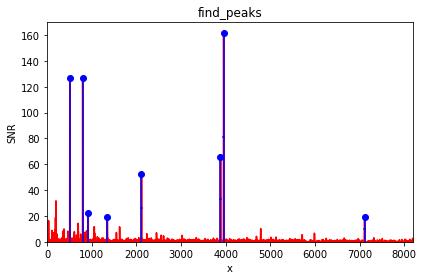

In [7]:
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find_peaks_spec',dpi = 200)

found best gain: 0.369757 keV/channel
fit gain: 0.369756699383546 keV/channel
fit channels: [ 914.5 3881.5 3950.5 7107.5]


C:\anaconda3\lib\site-packages\becquerel\core\spectrum.py:440: DeprecationWarning: energies_kev is deprecated and will be removed in a future release. Use bin_centers_kev instead.
  DeprecationWarning)


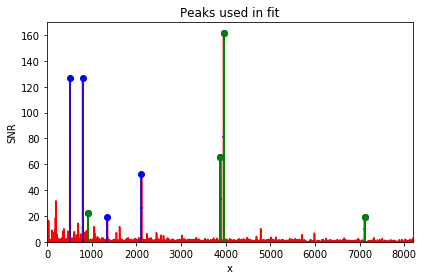

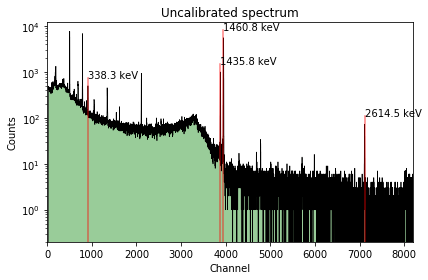

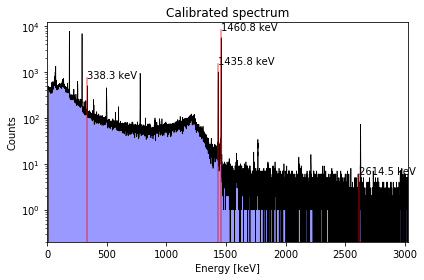

In [8]:
# perform calibration
cal.fit(
    [1435.795, 1460.82,2614.51],
    optional=[201.83,306.78, 351.93, 338.32,569.33,604.721,788.742,795.864, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.3, 10],
    de_max=100.,
)
plot_calibrator(cal)
spectrum = cal.peakfinder.spectrum


[246.5, 539.5, 706.5, 1564.5, 1792.5, 1874.5, 2827.5, 4560.5, 5518.5]


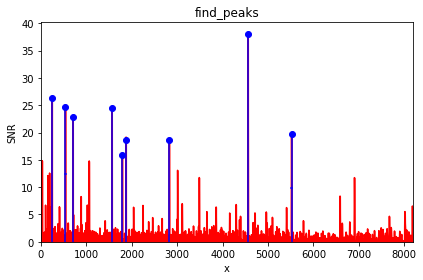

In [9]:
kernel = bq.GaussianPeakFilter(3700, 10, 5)
finder = bq.PeakFinder(bg, kernel)
cal = bq.AutoCalibrator(finder)
cal.peakfinder.find_peaks(min_snr=15, xmin=200)
print(cal.peakfinder.channels)
plt.figure()
plt.title('find_peaks')
cal.peakfinder.plot()
plt.tight_layout()
#plt.savefig('find peaks bg.png',dpi=200)

found best gain: 0.320388 keV/channel
fit gain: 0.3203875656420919 keV/channel
fit channels: [2827.5 4560.5 5518.5]


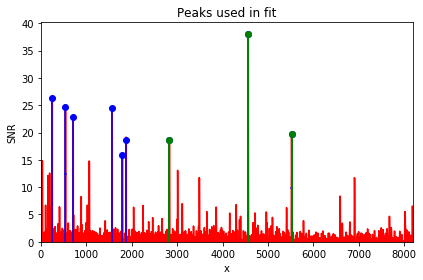

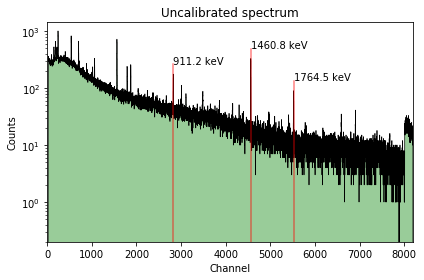

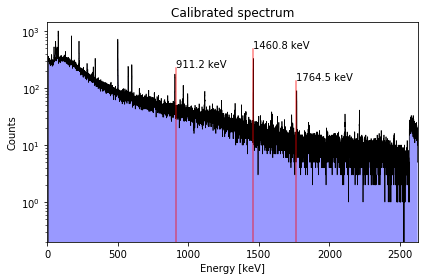

In [10]:
# perform calibration
cal.fit(
    [1460.82, 1764.49],
    optional=[186.21,238.63,609.32,911.20,242.00,295.22,338.32,351.93,1620.50],
    gain_range=[2.5e-2, 10],
    de_max=100.,
)
plot_calibrator(cal)
background = cal.peakfinder.spectrum

In [11]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                            'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([75,186,294,
                           782,1435.795,
                           1460]);
source_activities = np.array([16.259,16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L
branching_ratio = np.array([0.11,0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([1.6259,1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''

In [12]:
roi = ROI.ROI(spectrum, background, source_energies, sub_type = 0)
delta_e = 8
window = np.array([[-2, -1], [-0.5, 0.5], [1, 2]])
roi.set_sideband(delta_e,window)
roi.find_peak_energies()
target_peaks = roi.target_peaks
roi_result,roi_uncer = roi.get_counts()
#peakfit = PF.PF(spectrum,background,source_energies)
#pf_result = peakfit.get_counts()
print(target_peaks)
print('ROI result:',roi_result)
print('uncertainties:',roi_uncer)
#print('Lu_176 PF result:',pf_result)

[  73.  188.  294.  781. 1436. 1461.]
ROI result: [2596.5247040565196, 31006.15861519871, 30343.35690844646, 4866.817555743262, 6036.744753040266, 34716.065806756684]
uncertainties: [150.45168842285847, 209.62517081849498, 193.4162125569682, 84.31929039228537, 82.454446425295, 187.95596184992448]


[  73.  188.  294.  781. 1436. 1461.]


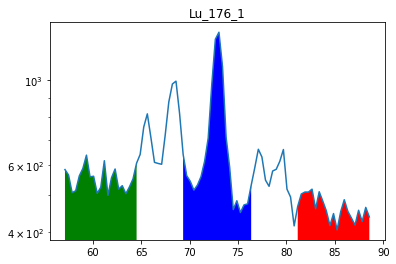

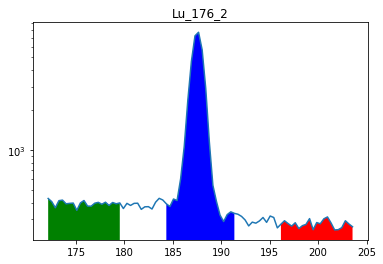

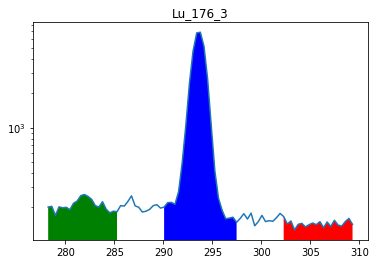

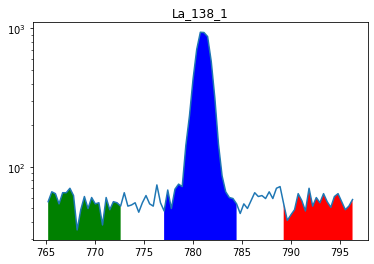

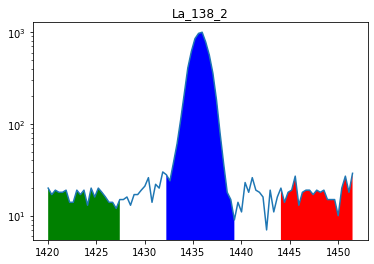

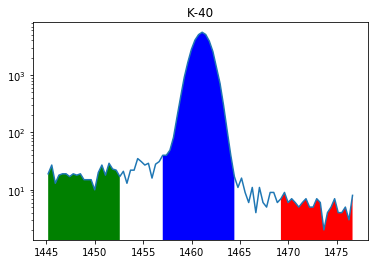

In [13]:
plot_peak_region(spectrum,source_energies,source_isotopes)

In [14]:
eff,eff_uncer = efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer)
print(eff,eff_uncer)

[0.02016384945506886, 0.030798047584218818, 0.027574614165726347, 0.017070917627413595, 0.01090811217865924, 0.01032224571356943] [0.002330425276782594, 0.0030868352987196567, 0.002763057671264375, 0.0002977232991286779, 0.00015057977482501068, 5.957678706261503e-05]


In [15]:
class Efficiency(object):
    """
    Object for undertaking the Efficiency Calibration of a detector.
    Currently only plots the Efficiency versus Energy data and the fitted curve.
    """

    def __init__(self,source_energies,eff,eff_uncer):
        
        self.energy = source_energies
        self.values = eff
        self.unc = eff_uncer
        self.x = []
        self.y = []
        self.space = np.linspace(1, 2160, 540)
        self.z = []
        self.fit = []
        self.new_fit = []

    def mutate(self):
        """
        Mutates data and creates the fit function.
        """
        for i in self.energy: 
            self.x.append(np.log(i/1461))
        for i in self.values:
            self.y.append(np.log(i))
        self.z = np.polyfit(np.asarray(self.x), np.asarray(self.y), 4)

    def normal(self, x): 
        return np.log(x/1461)

    def func3(self, x): 
        return (self.z[0]*self.normal(x)**4)+(self.z[1]*self.normal(x)**3)+(self.z[2]*self.normal(x)**2)+(self.z[3]*self.normal(x))+(self.z[4])

    def new_func(self, x): 
        return np.exp(func3(x))

    def fitting(self):
        """
        Fits the data.
        """
        for i in self.space:
            self.fit.append(self.func3(i))
        for i in self.fit:
            self.new_fit.append(np.exp(i))

    def plotter(self):
        """
        Plots the data and the fit.
        """
        plt.title('Efficiency Curve')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Efficiency')
        plt.errorbar(self.energy, self.values,yerr=self.unc, fmt ='o',elinewidth=2,capsize=4)
        plt.plot(self.energy, self.values, 'ro')
        plt.grid()
        plt.plot(self.space, self.new_fit)
        plt.legend(('Data Points', 'Fitted Curve'), loc='upper right')
        plt.ylim(0, 0.04)
        #plt.savefig('eff_curve.png',dpi=200)
        plt.show()
        
    def main(self):
        self.mutate()
        self.fitting()
        self.plotter()


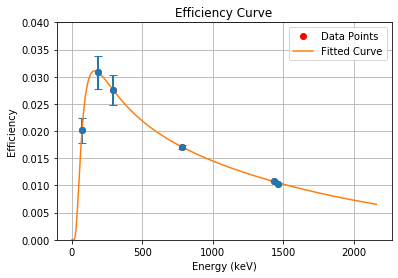

In [16]:
plot_eff = Efficiency(source_energies,eff,eff_uncer)
plot_eff.main()